# Cora Node Classification with a Minimal 2-Layer GCN
#### Additional Lab for Graph Nets - subcontent in Image Captioning Subject
#### Advanced Topics on CV - MIM/HUS 2025-2026

Two data modes:
1) Auto-download `cora.content` & `cora.cites` if internet works.
2) Local files: put them next to this notebook and set `DATA_SRC='local'`.

In [9]:

#!pip -q install numpy pandas matplotlib


In [10]:
import os, urllib.request, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch import optim
SEED=42; np.random.seed(SEED); torch.manual_seed(SEED)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

CORA_PATH = "/content/cora/"
DATA_SRC='local'  # or 'local'

CONTENT_URLS=[
 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.content',
 'https://raw.githubusercontent.com/kimiyoung/planetoid/master/data/cora.content']
CITES_URLS=[
 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.cites',
 'https://raw.githubusercontent.com/kimiyoung/planetoid/master/data/cora.cites']

def try_download(url,dest):
    try: urllib.request.urlretrieve(url,dest); return True
    except Exception as e: print('Download fail:', e); return False

def ensure_files(mode='auto', CORAPATH=''):
    if mode=='local':
        assert os.path.exists(CORAPATH+'cora.content') and os.path.exists(CORAPATH+'cora.cites')
        return CORA_PATH+'cora.content', CORAPATH+'cora.cites'
    cp, sp = CORA_PATH+'cora.content', CORAPATH+'cora.cites'
    if not os.path.exists(cp):
        ok=False
        for u in CONTENT_URLS:
            if try_download(u, cp): ok=True; break
        if not ok: print('Failed to get cora.content; switch to local.')
    if not os.path.exists(sp):
        ok=False
        for u in CITES_URLS:
            if try_download(u, sp): ok=True; break
        if not ok: print('Failed to get cora.cites; switch to local.')
    return cp, sp

cp, sp = ensure_files(DATA_SRC, CORA_PATH)
print('Using files:', cp, sp)

Device: cuda
Using files: /content/cora/cora.content /content/cora/cora.cites


In [11]:
content=pd.read_csv(cp, sep='\t', header=None)
node_ids=content[0].values
X=content.iloc[:,1:-1].to_numpy(dtype=np.float32)
labels_str=content.iloc[:,-1].values
classes={c:i for i,c in enumerate(sorted(set(labels_str)))}
y=np.array([classes[s] for s in labels_str], dtype=np.int64)
id2idx={nid:i for i,nid in enumerate(node_ids)}

edges=pd.read_csv(sp, sep='\t', header=None).to_numpy()
N=X.shape[0]; A=np.zeros((N,N), dtype=np.float32)
for s,d in edges:
    if s in id2idx and d in id2idx:
        i,j=id2idx[s], id2idx[d]; A[i,j]=A[j,i]=1.0
print(N)

2708


In [12]:
def normalize_adjacency(A):
    I=np.eye(A.shape[0], dtype=np.float32); At=A+I
    deg=At.sum(1); D=np.diag(np.power(deg,-0.5, where=deg>0))
    return (D@At@D).astype(np.float32)

def split_indices(n, labels, train_per_class=20, val_size=500, test_size=1000):
    rng=np.random.default_rng(SEED); byc={}
    for i,l in enumerate(labels): byc.setdefault(l,[]).append(i)
    tr=[];
    for c,idxs in byc.items():
        rng.shuffle(idxs); tr+=idxs[:train_per_class]
    rest=[i for i in range(n) if i not in tr]; rng.shuffle(rest)
    va=rest[:val_size]; te=rest[val_size:val_size+test_size]
    return np.array(tr), np.array(va), np.array(te)

In [13]:
A_hat=normalize_adjacency(A)
tr_idx, va_idx, te_idx = split_indices(N, y)

X_t=torch.tensor(X, dtype=torch.float32, device=device)
A_t=torch.tensor(A_hat, dtype=torch.float32, device=device)
y_t=torch.tensor(y, dtype=torch.long, device=device)
tr_t=torch.tensor(tr_idx, dtype=torch.long, device=device)
va_t=torch.tensor(va_idx, dtype=torch.long, device=device)
te_t=torch.tensor(te_idx, dtype=torch.long, device=device)

### - Thêm một tầng GCN nữa và quan sát hiện tượng over-smoothing.
### - Bỏ Dropout và Weight decay

In [35]:
class GCNLayer(nn.Module):
    def __init__(self,in_dim,out_dim): super().__init__(); self.lin=nn.Linear(in_dim,out_dim)
    def forward(self,X,A): return self.lin(A@X)

class GCN(nn.Module):
    def __init__(self,in_dim,hid,out_dim):# Đã bỏ dropout drop=0.5
        super().__init__()
        self.g1=GCNLayer(in_dim,hid)
        self.g2=GCNLayer(hid,hid) # Thêm một tầng ẩn trung gian
        self.g3=GCNLayer(hid,out_dim) # Tầng đầu ra cuối cùng
        # self.do=nn.Dropout(drop)
    def forward(self,X,A):
        H = torch.relu(self.g1(X,A))
        H = self.do(H)
        H = torch.relu(self.g2(H,A)) # Truyền qua tầng ẩn thứ hai
        H = self.do(H)
        return self.g3(H,A)
    def embed(self,X,A):
        H = torch.relu(self.g1(X,A))
        H = torch.relu(self.g2(H,A))
        return H # Nhúng từ tầng ẩn thứ hai

In [36]:
class GCNClassifier(nn.Module):
  def __init__(self, in_dim , hid_dim , num_classes):
    super().__init__()
    self.gcn1 = GCNLayer(in_dim , hid_dim)
    self.gcn2 = GCNLayer(hid_dim , hid_dim) # Now an intermediate layer
    self.gcn3 = GCNLayer(hid_dim, num_classes) # New third layer

  def forward(self, X, A_hat):
    H = self.gcn1(X, A_hat)
    H = F.relu(H)
    # H = F.dropout(H, p=0.5, training=self.training)
    H = self.gcn2(H, A_hat)
    H = F.relu(H)
    # H = F.dropout(H, p=0.5, training=self.training) # Dropout after the second ReLU
    H = self.gcn3(H, A_hat) # Pass through the new third layer
    return H # (N, num_classes)

  def embed(self, X, A_hat):
    H = self.gcn1(X, A_hat)
    H = F.relu(H)
    H = self.gcn2(H, A_hat)
    H = F.relu(H)
    return H # Return embeddings after the second layer

Epoch 20: loss=0.0029, val_acc=0.744
Epoch 40: loss=0.0000, val_acc=0.738
Epoch 60: loss=0.0000, val_acc=0.736
Epoch 80: loss=0.0000, val_acc=0.736
Epoch 100: loss=0.0000, val_acc=0.734
Epoch 120: loss=0.0000, val_acc=0.736
Epoch 140: loss=0.0000, val_acc=0.740
Epoch 160: loss=0.0000, val_acc=0.742
Epoch 180: loss=0.0000, val_acc=0.742
Epoch 200: loss=0.0000, val_acc=0.744


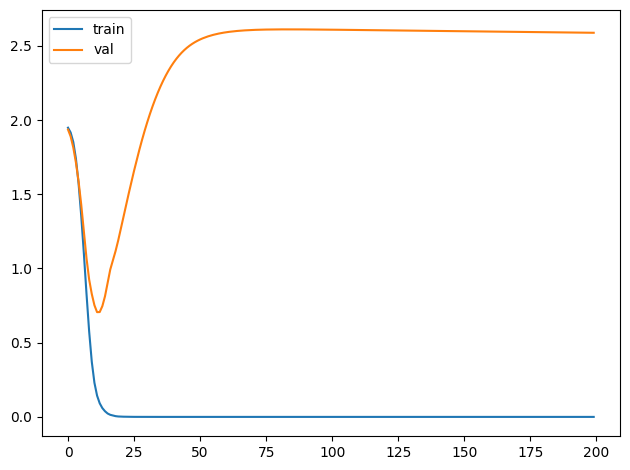

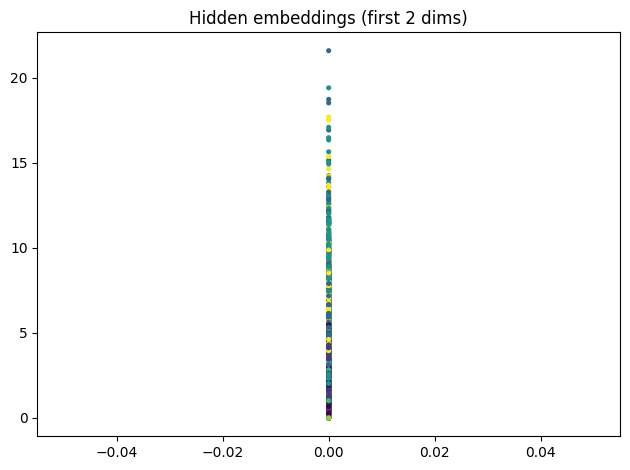

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A_hat = A_t # Use A_t from previous cell
X = X_t # Use X_t from previous cell
y = y_t # Use y_t from previous cell
EPOCHS=200; hist={'tr':[],'va':[]}; best=(1e9,None)

model = GCNClassifier(in_dim=X.shape[1],
hid_dim=64,
num_classes=y.max().item() + 1).to(device)

optimizer = torch.optim.Adam(model.parameters(),
lr=1e-2) #đã bỏ weight decay weight_decay=5e-4

criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS + 1):
  model.train()
  logits = model(X, A_hat)
  loss = criterion(logits[tr_t], y[tr_t]) # Use tr_t
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    o = model(X, A_hat)
    vloss = criterion(o[va_t], y[va_t]).item()
    pred_val = o[va_t].argmax(dim=1) # Use va_t
    acc_val = (pred_val == y[va_t]).float().mean().item()
  hist['tr'].append(float(loss.item())); hist['va'].append(float(vloss))
  if epoch % 20 == 0:
    print(f"Epoch {epoch}: loss={loss.item():.4f}, val_acc={acc_val:.3f}")


import matplotlib.pyplot as plt
plt.figure(); plt.plot(hist['tr'],label='train'); plt.plot(hist['va'],label='val'); plt.legend(); plt.tight_layout(); plt.show()

with torch.no_grad(): H=model.embed(X_t,A_t).cpu().numpy()
plt.figure(); plt.scatter(H[:,0],H[:,1],c=y.cpu().numpy(),s=7); plt.title('Hidden embeddings (first 2 dims)'); plt.tight_layout(); plt.show()

## Biểu diễn bằng t-SNE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


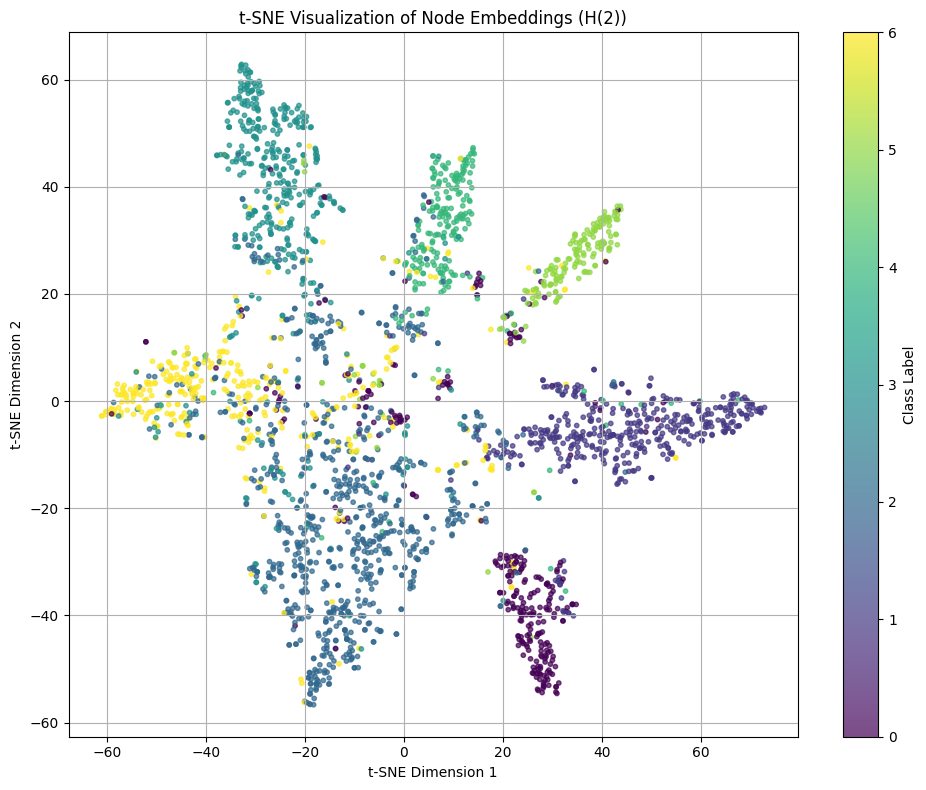

In [33]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

with torch.no_grad():
    H = model.embed(X_t, A_t).cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
H_tsne = tsne.fit_transform(H)

# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(H_tsne[:, 0], H_tsne[:, 1], c=y.cpu().numpy(), cmap='viridis', s=10, alpha=0.7)
plt.title('t-SNE Visualization of Node Embeddings (H(2))')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Class Label')
plt.grid(True)
plt.tight_layout()
plt.show()